In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [16]:
#filename = './Output_2018_2021_Braidwood_periodic/synthetic.csv'
filename = "./Output_Braidwood_2011_2021_DA_periodic/synthetic.csv"
synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
synthetic_df

,hour,Year,synthetic price
0,1,2011,24.271136
1,1,2012,19.693115
2,1,2013,30.131885
3,1,2014,24.059568
4,1,2015,17.480098
...,...,...,...
341607,8760,2017,59.575240
341608,8760,2018,28.528879
341609,8760,2019,15.969281
341610,8760,2020,12.114794


In [14]:
data_dir = '../data/electricity_markets/PJM_braidwood/'
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  year = int(f.split('_')[0])
  file = data_dir+f
  df = pd.read_csv(file)
  df['Year'] = [year for i in range(len(df))]
  li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df

,hour,historical price,Year
0,1.0,25.02,2017
1,2.0,24.32,2017
2,3.0,24.17,2017
3,4.0,23.95,2017
4,5.0,24.09,2017
...,...,...,...
96355,8756.0,28.52,2021
96356,8757.0,26.37,2021
96357,8758.0,24.87,2021
96358,8759.0,24.80,2021


Merge historical and synthetic data

In [24]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,hour,historical price,Year,synthetic price
0,1.0,25.02,2017,17.545025
1,2.0,24.32,2017,23.105047
2,3.0,24.17,2017,19.201947
3,4.0,23.95,2017,17.543295
4,5.0,24.09,2017,20.533043
...,...,...,...,...
96355,8756.0,28.52,2021,30.528385
96356,8757.0,26.37,2021,31.308230
96357,8758.0,24.87,2021,26.844610
96358,8759.0,24.80,2021,27.170882


In [33]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)
stats_df

,historical price,synthetic price
count,96360.000000,96360.000000
mean,33.863077,33.863486
std,23.023076,23.066567
min,2.270000,2.270000
25%,23.270000,23.210845
50%,29.740000,29.737587
75%,38.210000,38.269651
max,933.680000,933.680000
kurtosis,225.343221,224.018395
skewness,10.278281,10.224953


In [31]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,25.020000
1,historical,24.320000
2,historical,24.170000
3,historical,23.950000
4,historical,24.090000
...,...,...
341607,synthetic,59.575240
341608,synthetic,28.528879
341609,synthetic,15.969281
341610,synthetic,12.114794


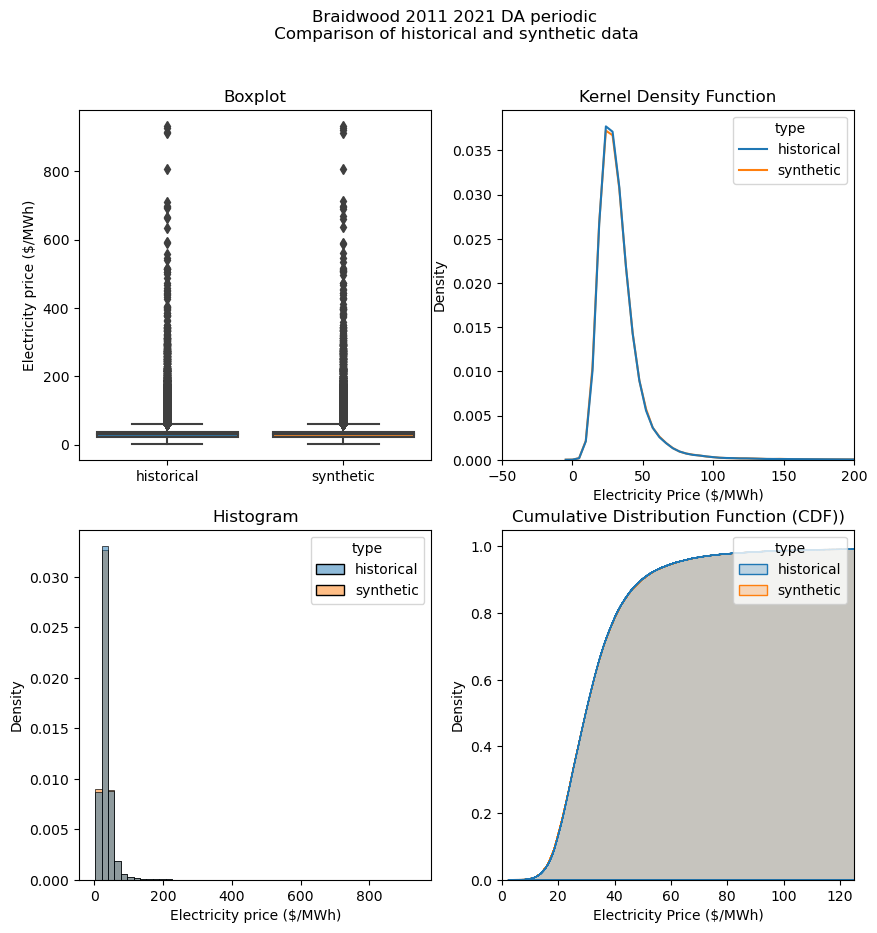

In [32]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(2,2,figsize =(10,10))

title = ' '.join(tag.split('_'))+'\n Comparison of historical and synthetic data'
fig.suptitle(title)

sns.boxplot(ax = axes[0,0],data=prices_df, x='type', y='price')
axes[0,0].set_title('Boxplot')
axes[0,0].set_ylabel('Electricity price ($/MWh)')
axes[0,0].set_xlabel('')

sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=50, stat='density', common_norm=False)
axes[1,0].set_title('Histogram')
axes[1,0].set_xlabel('Electricity price ($/MWh)')

sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type',common_norm=False)
axes[0,1].set_title('Kernel Density Function')
axes[0,1].set_xlabel('Electricity Price ($/MWh)')
axes[0,1].set_xlim(-50,200)

sns.histplot(ax = axes[1,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[1,1].set_title('Cumulative Distribution Function (CDF))')
axes[1,1].set_xlabel('Electricity Price ($/MWh)')
axes[1,1].set_xlim(0,125)

fig.savefig(tag+'_comparison_plots.png')

